# 风格迁移的实现

本文件是集智AI学园开发的“火炬上的深度学习”课程的配套源代码。我们讲解了Prisma软件实现风格迁移的实现原理

在这节课中，我们将学会玩图像的风格迁移。



我们需要准备两张图像，一张作为化作风格，一张作为图像内容

同时，在本文件中，我们还展示了如何实用GPU来进行计算 

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码

In [19]:
#导入必要的包
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# 是否用GPU计算，如果检测到有安装好的GPU，则利用它来计算
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

## 一、准备输入文件

我们需要准备两张同样大小的文件，一张作为风格，一张作为内容

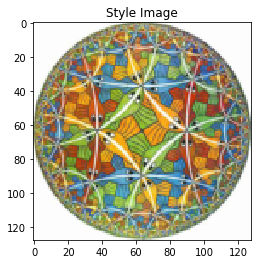

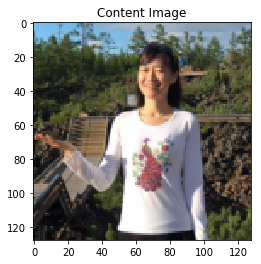

In [27]:
#风格图像的路径
style = 'images/escher.jpg'

#内容图像的路径
content = 'images/portrait1.jpg'


#风格损失所占比重
style_weight=1000

#内容损失所占比重
content_weight=1

#如果内容损失越大，则结果图像就会尽可能保持图像内容不变，否则它会尽可能让风格更靠近目标画作的风格


#注意，这两张图片必须同样大小

#希望得到的图片大小（越大越清晰，计算越慢）
imsize = 128

loader = transforms.Compose([
    transforms.Scale(imsize),  # 将加载的图像转变为指定的大小
    transforms.ToTensor()])  # 将图像转化为tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = torch.tensor(loader(image), requires_grad = True)
    # 为了适应卷积网络的需要，虚拟一个batch的维度
    image = image.unsqueeze(0)
    return image

style_img = image_loader(style).type(dtype)
content_img = image_loader(content).type(dtype)

assert style_img.size() == content_img.size(), \
    "我们需要输入相同尺寸的风格和内容图像"


unloader = transforms.ToPILImage()  # 将其转化为PIL图像（Python Imaging Library） 

plt.ion()

# 绘制图像的函数
def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # 克隆Tensor防止改变
    image = image.view(3, imsize, imsize)  # 删除添加的batch层本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 停一会以便更新视图

# 打印输入的两张图片看一下
plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

## 二、风格迁移网络的实现

值得注意的是，风格迁移的实现并没有训练一个神经网络，而是将已训练好的卷积神经网络价格直接迁移过来
网络的学习过程并不体现为对神经网络权重的训练，而是训练一张输入的图像，让它尽可能地靠近内容图像的内容和风格图像的风格

为了实现风格迁移，我们需要在迁移网络的基础上再构建一个计算图，这样可以加速计算。构建计算图分为两部：

1、加载一个训练好的CNN；

2、在原网络的基础上添加计算风格损失和内容损失的新计算层

### 1. 加载已训练好的大型网络VGG

In [21]:
cnn = models.vgg19(pretrained=True).features

# 如果可能就用GPU计算:
if use_cuda:
    cnn = cnn.cuda()

### 2. 重新定义新的计算模块

In [22]:
# 计算内容损失的神经模块
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 由于网络的权重都是从target上迁移过来，所以在计算梯度的时候，需要把它和原始计算图分离
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input为一个特征图
        # 它的功能就是计算误差，误差就是当前计算的内容与target之间的均方误差
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        # 开始进行反向传播算法
        self.loss.backward(retain_variables=retain_variables)
        return self.loss
    
class StyleLoss(nn.Module):
    
    # 计算风格损失的神经模块

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        #self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input就是一个特征图
        self.output = input.clone()
        # 计算本图像的gram矩阵，并将它与target对比
        input = input.cuda() if use_cuda else input
        self_G = Gram(input)
        self_G.mul_(self.weight)
        # 计算损失函数，即输入特征图的gram矩阵与目标特征图的gram矩阵之间的差异
        self.loss = self.criterion(self_G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        # 反向传播算法
        self.loss.backward(retain_variables=retain_variables)
        return self.loss
    
def Gram(input):
    # 输入一个特征图，计算gram矩阵
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=特征图的数量
    # (c,d)=特征图的图像尺寸 (N=c*d)

    features = input.view(a * b, c * d)  # 将特征图图像扁平化为一个向量

    G = torch.mm(features, features.t())  # 计算任意两个像素之间的乘积

    # 我们通过除以特征图中的像素数量来归一化特征图
    return G.div(a * b * c * d)

In [23]:

# 希望计算的内容或者风格层 :
content_layers = ['conv_4'] #只考虑第四个卷积层的内容


style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 考虑第1、2、3、4、5层的风格损失


# 定义列表存储每一个周期的计算损失
content_losses = []
style_losses = []

model = nn.Sequential()  # 一个新的序贯网络模型

# 如果有GPU就把这些计算挪到GPU上:
if use_cuda:
    model = model.cuda()


    
    
# 接下来要做的操作是：循环vgg的每一层，同时构造一个全新的神经网络model
# 这个新网络与vgg基本一样，只是多了一些新的层来计算风格损失和内容损失。
# 将每层卷积核的数据都加载到新的网络模型model上来
i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        #将已加载的模块放到model这个新的神经模块中
        model.add_module(name, layer)

        if name in content_layers:
            # 如果当前层模型在定义好的要计算内容的层:
            target = model(content_img).clone() #将内容图像当前层的feature信息拷贝到target中
            content_loss = ContentLoss(target, content_weight) #定义content_loss的目标函数
            content_loss = content_loss if use_cuda else content_loss
            model.add_module("content_loss_" + str(i), content_loss) #在新网络上加content_loss层
            content_losses.append(content_loss)

        if name in style_layers:
            # 如果当前层在指定的风格层中，进行风格层损失的计算
            target_feature = model(style_img).clone()
            target_feature = target_feature.cuda() if use_cuda else target_feature
            target_feature_gram = Gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            style_loss = style_loss.cuda() if use_cuda else style_loss
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        #如果不是卷积层，则做同样处理
        name = "relu_" + str(i)
        model.add_module(name, layer)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***



## 二、风格迁移的训练

### 1. 首先，我们需要现准备一张原始的图像，可以是一张噪音图或者就是内容图

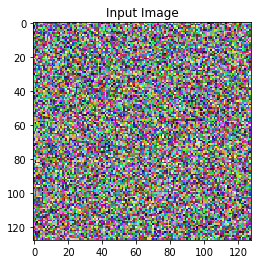

In [24]:

# 如果想从调整一张噪声图像开始，请用下面一行的代码
input_img = torch.randn(content_img.data.size(), requires_grad = True)

if use_cuda:
    input_img = input_img.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()
# 将选中的待调整图打印出来:
plt.figure()
imshow(input_img.data, title='Input Image')

### 2. 优化输入的图像（训练过程）

正在构造风格迁移模型..
开始优化..
运行 [301]轮:
风格损失 : 192.922943 内容损失: 25.963591

运行 [301]轮:
风格损失 : 0.591812 内容损失: 2.861641

运行 [301]轮:
风格损失 : 0.518782 内容损失: 1.806555

运行 [301]轮:
风格损失 : 0.568853 内容损失: 1.847947

运行 [301]轮:
风格损失 : 0.549346 内容损失: 1.834683

运行 [301]轮:
风格损失 : 0.795242 内容损失: 2.585810



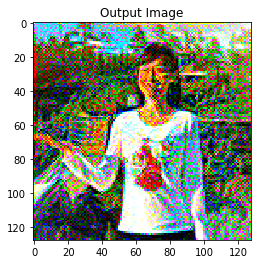

In [29]:
# 首先，需要先讲输入图像变成神经网络的参数，这样我们就可以用反向传播算法来调节这个输入图像了
input_param = nn.Parameter(input_img.data)

#定义个优化器，采用LBFGS优化算法来优化（试验效果很好，它的特点是可以计算大规模数据的梯度下降）
optimizer = optim.LBFGS([input_param])

# 迭代步数
num_steps=300


"""运行风格迁移的主算法过程."""
print('正在构造风格迁移模型..')

print('开始优化..')
for i in range(num_steps):
    #每一个训练周期
    
    # 限制输入图像的色彩取值范围在0-1间
    input_param.data.clamp_(0, 1)
    
    # 清空梯度
    optimizer.zero_grad()
    # 将图像输入构造的神经网络中
    model(input_param)
    style_score = 0
    content_score = 0
    
    # 每个损失函数层都开始反向传播算法
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()

    # 每隔50个周期打印一次训练数据
    if i % 50 == 0:
        print("运行 {}轮:".format(run))
        print('风格损失 : {:4f} 内容损失: {:4f}'.format(
            style_score.data[0], content_score.data[0]))
        print()
    def closure():
        return style_score + content_score
    #一步优化
    optimizer.step(closure)

# 做一些修正，防止数据超界...
output = input_param.data.clamp_(0, 1)

# 打印结果图
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码